In [1]:
import os
from pathlib import Path

def root_dir(marker="EXPLib"):
    cwd = Path.cwd()
    # if cwd already contains the marker
    if (cwd / marker).is_dir():
        return cwd
    # otherwise walk up the parents
    for p in cwd.parents:
        if (p / marker).is_dir():
            return p
    raise FileNotFoundError(f"Root marker '{marker}' not found")

os.chdir(root_dir())
#print(os.getcwd())

In [2]:
from EXPLib.xai_library.model_explainers.model_utils.toymodel_utils import load_and_configure_model, preprocess_image
from EXPLib.xai_library.model_explainers.uncertainty_models.toymodel_uncertainties import SSDWithDropout, setup_parallel_models, predict_with_parallel_models
from EXPLib.xai_library.model_explainers.uncertainty_models import  toymodel_uncertainties
import torch

image_path = './EXPLib/datasets/Camera/toy_model_v1_inference/dev/images'
image_file = 'rgb_0000079.png'
weight_path = './EXPLib/dl_component/CNN/Object_Detectors/toy_model_v1'
weight_file = 'aikonet_toymodelv1_ssdlite.pth'
model_name = "ssdlite320_mobilenet_v3_large"
num_classes = 2

############################################################################
# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
toymodel = load_and_configure_model(model_name, weight_path, weight_file, num_classes, device)
toymodel.eval()
image = preprocess_image(image_path, image_file, device)
#prediction = toymodel(image)

In [4]:
model_with_dropout = SSDWithDropout(toymodel, 0.1) # drop out 10%
toymodel_MC = setup_parallel_models(model_with_dropout, 100) # Setup a number of parallel models. Tune this parameter for speed

In [5]:
outputs = predict_with_parallel_models(toymodel_MC, image, 5) # Run prediction, the number is number of sequential run. Can combine with number of parallel models for speed and memory tradeoff

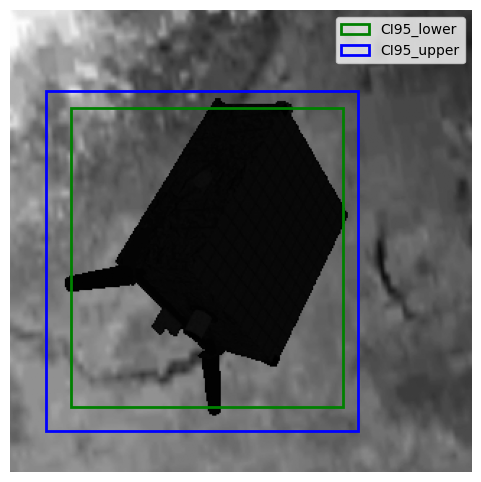

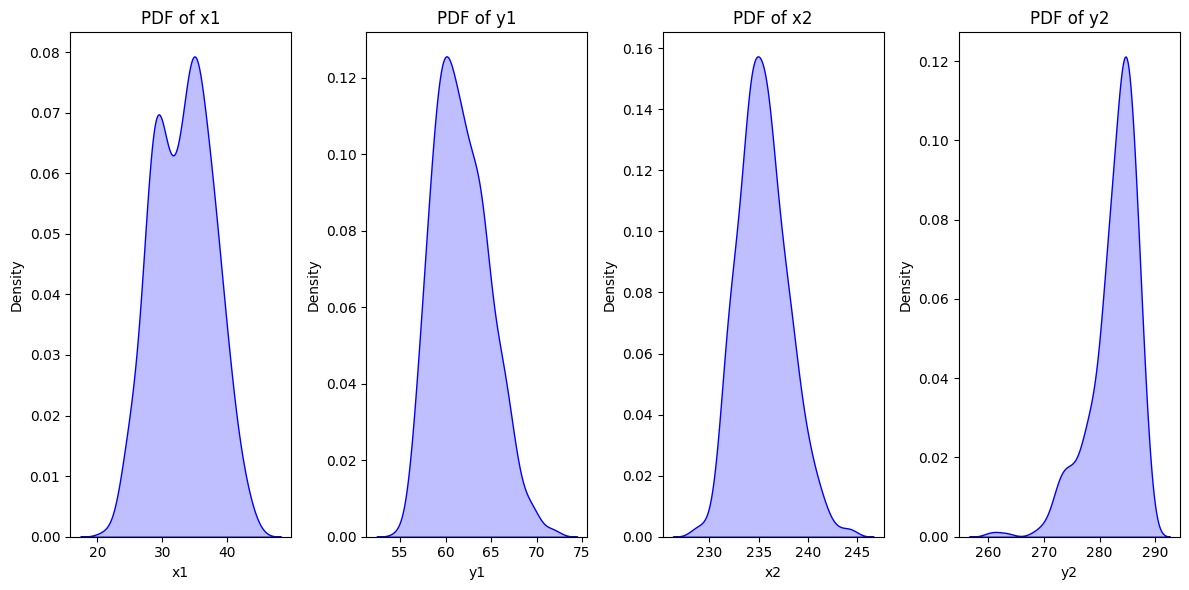

In [6]:
toymodel_uncertainties.plot_image_with_bboxes(image.cpu(), (outputs['bbox_CI95'][0].cpu(), outputs['bbox_CI95'][1].cpu()), outputs['bbox_mean'].cpu())

toymodel_uncertainties.plot_bbox_pdfs(outputs['bbox_all'].cpu())